In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
path="../../data/"
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
#!pip install OSGridConverter

In [3]:
from OSGridConverter import grid2latlong

In [4]:
'''
Helper function to find out columns containing specific text
'''
def findcols(df,text):
    return [col for col in df.columns if text in col]

In [5]:
ukb_tp0=pd.read_pickle('%s%s' % (path,'ukb_tp0.p'))

In [6]:
diseases_bin=pd.read_pickle('%s%s' % (path,'ukb_disease_labels.p'))

In [30]:
outputs_score=pd.read_pickle('%s%s' % (path,'outputs_score.p'))

In [32]:
ukb_tp0['rounded_matches_f20023']=(ukb_tp0['mean_time_to_correctly_identify_matches_f20023']/50).round()*10
ukb_tp0['airpoll_24006']=ukb_tp0['particulate_matter_air_pollution_pm25_2010_f24006'].round()
ukb_tp0['airpoll_24007']=ukb_tp0['particulate_matter_air_pollution_pm25_absorbance_2010_f24007'].round()
ukb_tp0['uk_north_coord']=(ukb_tp0['place_of_birth_in_uk_north_coordinate_f129']/100000).round()*100000
ukb_tp0['uk_east_coord']=(ukb_tp0['place_of_birth_in_uk_east_coordinate_f130']/100000).round()*100000

In [40]:
def combineanalyse(df1,df2):
    df_out=pd.merge(df1,df2,left_on='eid',right_on='n_eid',how='left')
    return df_out    

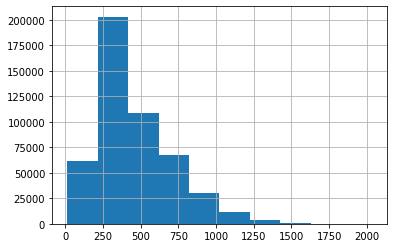

In [103]:
ukb_tp0['sex_inference_y_probeintensity_f22023'].hist()

In [45]:
dis_vars=['n_eid','Age_Today','AD','PD','Diag_Date_AD','years_bef_diagAD',
                           'date_of_attending_assessment_centre_f53', 'age_when_attended_assessment_centre_f21003',
                           'EPIL','DIAB','CELIAC','CERVASC','CERVASC_bef','EPIL_bef','DIAB_bef']

In [42]:
shap_vars=['eid','Genotype','particulate_matter_air_pollution_pm25_2010_f24006','airpoll_24006','airpoll_24007',
       'mean_time_to_correctly_identify_matches_f20023','rounded_matches_f20023',
       'number_of_treatmentsmedications_taken_f137',
       'sleeplessness_insomnia_f1200',
       'particulate_matter_air_pollution_pm25_absorbance_2010_f24007',
       'never_eat_eggs_dairy_wheat_sugar_f6144',
       'uk_east_coord',
       'parental_ad_status',
       'uk_north_coord',
       'particulate_matter_air_pollution_pm10_2010_f24005',
       'time_spent_driving_f1090', 'creactive_protein_f30710',
       'alanine_aminotransferase_f30620',
       'answered_sexual_history_questions_f2129',
       'neutrophill_count_f30140', 'carer_support_indicators_f41214',
       'drive_faster_than_motorway_speed_limit_f1100',
       'history_of_psychiatric_care_on_admission_f41218',
       'particulate_matter_air_pollution_2510um_2010_f24008',
       'frequency_of_solariumsunlamp_use_f2277',
       'hand_grip_strength_left_f46', 'glycated_haemoglobin_hba1c_f30750',
       'frequency_of_tenseness_restlessness_in_last_2_weeks_f2070',
       'forced_expiratory_volume_in_1second_fev1_best_measure_f20150']

In [51]:
ukb_shap=ukb_tp0[shap_vars]
ukb_shap=pd.merge(ukb_shap,diseases_bin[dis_vars],left_on='eid',right_on='n_eid',how='left')
ukb_shap=pd.merge(ukb_shap,outputs_score,on='eid',how='inner')
ukb_shap.to_csv('%s%s' % (path,'ukb_shap.csv'))

In [87]:
ukb_cols_filt=[col for col in ukb_tp0.columns if 
               (ukb_tp0[col].count()>400000 and len(ukb_tp0[col].value_counts())<100) or col=='eid' or col in dis_vars]

In [88]:
ukb_filt0=ukb_tp0[ukb_cols_filt]

In [89]:
ukbfilttemp=pd.merge(ukb_filt0[['eid']],diseases_bin[dis_vars],left_on='eid',right_on='n_eid',how='left')

In [90]:
ukb_filt0[dis_vars]=ukbfilttemp[dis_vars]

In [91]:
age_mask=(ukb_filt0['Age_Today']>=75)
ukb_filt0=ukb_filt0[age_mask]

In [93]:
ukb_cols_filt2=np.append(ukb_cols_filt,['CERVASC_bef','EPIL_bef','DIAB_bef','PD'])

In [94]:
ukb_filt0['APOE4']=0
apoe_mask=(ukb_filt0['Genotype']=="e4/e4")|(ukb_filt0['Genotype']=="e3/e4")|(ukb_filt0['Genotype']=="e2/e4")
ukb_filt0['APOE4'][apoe_mask]=1

In [95]:
df1=pd.DataFrame(ukb_filt0.groupby('APOE4')['AD'].mean()).reset_index()
df1.columns=['APOE4','ADRate_avg']

df_full=pd.DataFrame()
for col in ukb_cols_filt2:
    if col !='eid':
        df=pd.DataFrame(ukb_filt0.groupby(['APOE4',col]).agg({'AD':['mean','count','sum']})).reset_index()
        df.columns=['APOE4','breakdown','ADrate','recs','num_AD']
        
        df=pd.merge(df,df1,on='APOE4',how='inner')
       
        df['ADrate']=df['ADrate']/df['ADRate_avg']

        
        
        df['variable']=col
        df_full=pd.concat([df_full,df],axis=0)
df_full

,APOE4,breakdown,ADrate,recs,num_AD,ADRate_avg,variable
0,0,2-4 times a week,1.033421,7066,64.0,0.008765,able_to_confide_f2110
1,0,About once a month,1.063007,4508,42.0,0.008765,able_to_confide_f2110
2,0,About once a week,0.920922,9292,75.0,0.008765,able_to_confide_f2110
3,0,Almost daily,0.885976,43914,341.0,0.008765,able_to_confide_f2110
4,0,Do not know,1.431853,3028,38.0,0.008765,able_to_confide_f2110
...,...,...,...,...,...,...,...
3,1,1,0.770953,2827,66.0,0.030282,DIAB_bef
0,0,0,0.934317,86581,709.0,0.008765,PD
1,0,1,5.467292,1273,61.0,0.008765,PD
2,1,0,0.955736,25983,752.0,0.030282,PD


In [96]:
df_full.to_csv('%s%s' % (path,'variablesummary.csv'))

In [180]:
ukb_tp0['AD']=ukb_tp0_dvars['AD']

In [173]:
ukb_tp0.to_csv('%s%s' % (path,'ukb_tp0.csv'))

In [78]:
df_full[(df_full['variable'].str.contains('matches'))]

,APOE4,breakdown,ADrate,recs,num_AD,ADRate_avg,variable
0,0,10,0.0,1,0.0,0.008765,rounded_matches_f20023
1,0,20,0.0,2,0.0,0.008765,rounded_matches_f20023
2,0,40,0.0,1,0.0,0.008765,rounded_matches_f20023
3,0,50,0.0,2,0.0,0.008765,rounded_matches_f20023
4,0,60,0.0,10,0.0,0.008765,rounded_matches_f20023
...,...,...,...,...,...,...,...
69,1,340,0.0,5,0.0,0.030282,rounded_matches_f20023
70,1,350,0.0,2,0.0,0.030282,rounded_matches_f20023
71,1,360,0.0,1,0.0,0.030282,rounded_matches_f20023
72,1,370,0.0,1,0.0,0.030282,rounded_matches_f20023


In [115]:
vars_analyse=['eid','Genotype','recent_feelings_of_depression_f20510','sleeplessness_insomnia_f1200','parental_ad_status',
      'particulate_matter_air_pollution_pm25_2010_f24006',
      'number_of_symbol_digit_matches_made_correctly_f20159','sex_f31',
      'type_of_special_diet_followed_f20086','ever_used_hormonereplacement_therapy_hrt_f2814'
      ]

In [122]:
ukb_tp0_dvars=pd.merge(ukb_tp0[vars_analyse],
               diseases_bin[['n_eid','Age_Today','AD','Diag_Date_AD','years_bef_diagAD',
                           'date_of_attending_assessment_centre_f53', 'age_when_attended_assessment_centre_f21003',
                           'EPIL','DIAB','CELIAC','CERVASC','EPIL_bef','DIAB_bef']],
                      left_on='eid',right_on='n_eid',how='left')

In [125]:
ukb_tp0_score.columns

Index(['eid', 'Genotype', 'recent_feelings_of_depression_f20510',
       'sleeplessness_insomnia_f1200', 'parental_ad_status',
       'particulate_matter_air_pollution_pm25_2010_f24006',
       'number_of_symbol_digit_matches_made_correctly_f20159', 'sex_f31',
       'type_of_special_diet_followed_f20086',
       'ever_used_hormonereplacement_therapy_hrt_f2814', 'n_eid', 'Age_Today',
       'AD', 'Diag_Date_AD', 'years_bef_diagAD',
       'date_of_attending_assessment_centre_f53',
       'age_when_attended_assessment_centre_f21003', 'EPIL', 'DIAB', 'CELIAC',
       'CERVASC', 'EPIL_bef', 'DIAB_bef', 'mean_score', 'std_score'],
      dtype='object')

In [124]:
ukb_tp0_score=pd.merge(ukb_tp0_dvars,scoredf,on='eid',how='inner')

In [126]:
ukb_tp0_score.to_csv('%s%s' % (path,'ukb_tp0_score.csv'))

In [ ]:
def ageunits(df):
    ukb_time=df[['eid','Diag_Date_AD','AD','age_when_attended_assessment_centre_f21003',
                        'years_bef_diagAD', 'date_of_attending_assessment_centre_f53']]
    ukb_time['age']=ukb_time['age_when_attended_assessment_centre_f21003']
    ukb_time['years_fwd']=(dt.datetime.strptime('2020-01-01', '%Y-%m-%d')-\
    pd.to_datetime(ukb_time['date_of_attending_assessment_centre_f53'])).dt.days/365
    ukb_time=ukb_time[pd.notnull(ukb_time['years_fwd'])]

    ukb_time['time']=0
    new_rows = []
    for i, row in ukb_time.iterrows():
        for j in range(int(row['years_fwd'])): 
            row['time'] = j
            row['age']=row['age_when_attended_assessment_centre_f21003']+j
            newrow = row.copy()
            new_rows.append(newrow.values)


    ukb_time_full = pd.DataFrame(new_rows, columns=ukb_time.columns).reset_index()
    return ukb_time_full
    

In [ ]:
ukb_time_full=ageunits(ukb_tp0_dvars)

In [16]:
%%time
ukb_time=ukb_tp0_dvars[['eid','Diag_Date_AD','AD','age_when_attended_assessment_centre_f21003',
                        'years_bef_diagAD', 'date_of_attending_assessment_centre_f53']]

ukb_time['age']=ukb_time['age_when_attended_assessment_centre_f21003']
ukb_time['years_fwd']=(dt.datetime.strptime('2020-01-01', '%Y-%m-%d')-\
pd.to_datetime(ukb_time['date_of_attending_assessment_centre_f53'])).dt.days/365
ukb_time=ukb_time[pd.notnull(ukb_time['years_fwd'])]

ukb_time['time']=0
new_rows = []
for i, row in ukb_time.iterrows():
    for j in range(int(row['years_fwd'])): 
        row['time'] = j
        row['age']=row['age_when_attended_assessment_centre_f21003']+j
        newrow = row.copy()
        new_rows.append(newrow.values)
        

ukb_time_full = pd.DataFrame(new_rows, columns=ukb_time.columns).reset_index()

CPU times: user 25min 32s, sys: 43.4 s, total: 26min 15s
Wall time: 26min 15s


In [68]:
findcols(ukb_tp0_dvars,'CE')

['CELIAC']

In [25]:
ukb_time_full2=pd.merge(ukb_time,ukb_tp0_dvars[['eid','diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068',
                                               'EPIL','DIAB','EPIL_bef','DIAB_bef']],on='eid',how='left')

In [18]:
def drawline(df,varx,vary,huevar):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data = df, x=varx, y=vary, hue=huevar)

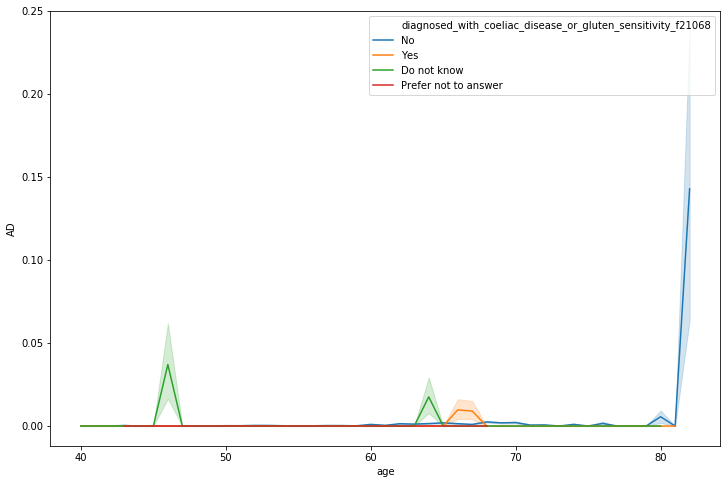

In [19]:
drawline(ukb_time_full2,"age","AD",'diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068')

In [96]:
ukb_tp0_dvars[(ukb_tp0_dvars['sex_f31']=="Female")].groupby(['ever_used_hormonereplacement_therapy_hrt_f2814'])['AD'].mean()

ever_used_hormonereplacement_therapy_hrt_f2814
Do not know             0.011127
No                      0.003351
Prefer not to answer    0.003788
Yes                     0.006556
Name: AD, dtype: float64

In [95]:
ukb_tp0_dvars['sex_f31'].value_counts()

Female    273378
Male      229115
Name: sex_f31, dtype: int64

In [94]:
findcols(ukb_tp0_dvars,'sex')

['sex_f31']

In [32]:
rule_coeliac=(ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068']=="Yes")
rule_coeliacno=(ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068']=="No")
rule_diaby=(ukb_tp0_dvars['DIAB_bef']==1)
rule_diabn=(ukb_tp0_dvars['DIAB_bef']==0)
rule_epily=(ukb_tp0_dvars['EPIL_bef']==1)
rule_epiln=(ukb_tp0_dvars['EPIL_bef']==0)
rule_age=(ukb_tp0_dvars['Age_Today']>75)
rule_AD=(ukb_tp0_dvars['AD']==1)

In [57]:
mask=(pd.isnull(ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068']))
ukb_tp0_dvars['diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068'][mask]="Missing"

In [75]:
findcols(ukb_tp0,'f20086')

['type_of_special_diet_followed_f20086']

In [81]:
ukb_tp0_dvars.groupby(['type_of_special_diet_followed_f20086'])['AD'].mean()

type_of_special_diet_followed_f20086
Gluten-free     0.004782
Lactose-free    0.002986
Low calorie     0.003086
Other           0.002945
Vegan           0.000000
Vegetarian      0.001918
Name: AD, dtype: float64

In [80]:
ukb_tp0_dvars.groupby(['AD'])['CERVASC'].sum()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [31]:
print(ukb_tp0_dvars[rule_diaby&rule_age]['AD'].mean())
print(ukb_tp0_dvars[rule_diabn&rule_age]['AD'].mean())

0.009862064369960686
0.01331081752259859


In [33]:
print(ukb_tp0_dvars[rule_epily&rule_age]['AD'].mean())
print(ukb_tp0_dvars[rule_epiln&rule_age]['AD'].mean())

0.03458957150232318
0.012559871412763414


In [61]:
ukb_tp0_dvars[rule_coeliac&rule_age]

,eid,diagnosed_with_coeliac_disease_or_gluten_sensitivity_f21068,n_eid,Age_Today,AD,Diag_Date_AD,years_bef_diagAD,date_of_attending_assessment_centre_f53,age_when_attended_assessment_centre_f21003,EPIL,DIAB
812,1009346,Yes,1009346.0,81.024658,0.0,None,NaN,2008-09-25,69.0,0.0,0.0
3088,1035528,Yes,1035528.0,75.167123,0.0,None,NaN,2009-08-04,64.0,0.0,0.0
4067,1046921,Yes,1046921.0,78.608219,0.0,None,NaN,2010-02-24,68.0,0.0,0.0
7280,1083940,Yes,1083940.0,78.241096,0.0,None,NaN,2008-07-08,66.0,0.0,0.0
7553,1087036,Yes,1087036.0,75.717808,0.0,None,NaN,2009-01-15,64.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
491654,5180927,Yes,5180927.0,75.293151,0.0,None,NaN,2008-06-19,63.0,0.0,0.0
493032,5288215,Yes,5288215.0,78.353425,0.0,None,NaN,2010-05-28,68.0,0.0,0.0
494931,5436855,Yes,5436855.0,80.112329,0.0,None,NaN,2009-08-24,69.0,0.0,0.0
495076,5447330,Yes,5447330.0,80.301370,0.0,None,NaN,2009-06-16,69.0,0.0,0.0


In [52]:
ukb_tp0_dvars[rule_coeliacno].shape


(170094, 11)

In [58]:
ukb_tp0_dvars[rule_coeliacno&rule_age]['AD'].mean()

0.002160790231856222

In [59]:
ukb_tp0_dvars[rule_age]['AD'].mean()

0.013747538831765478

In [42]:
ukb_tp0_dvars.shape

(4117737, 13)

In [43]:
findcols(ukb_tp0,'APOE')

['APOE4_Carriers']

In [48]:
[col for col in ukb_tp0.columns if 'genotype' in col]

['chromosome_10_genotype_results_f22110',
 'chromosome_11_genotype_results_f22111',
 'chromosome_12_genotype_results_f22112',
 'chromosome_13_genotype_results_f22113',
 'chromosome_14_genotype_results_f22114',
 'chromosome_15_genotype_results_f22115',
 'chromosome_16_genotype_results_f22116',
 'chromosome_17_genotype_results_f22117',
 'chromosome_18_genotype_results_f22118',
 'chromosome_19_genotype_results_f22119',
 'chromosome_1_genotype_results_f22101',
 'chromosome_20_genotype_results_f22120',
 'chromosome_21_genotype_results_f22121',
 'chromosome_22_genotype_results_f22122',
 'chromosome_2_genotype_results_f22102',
 'chromosome_3_genotype_results_f22103',
 'chromosome_4_genotype_results_f22104',
 'chromosome_5_genotype_results_f22105',
 'chromosome_6_genotype_results_f22106',
 'chromosome_7_genotype_results_f22107',
 'chromosome_8_genotype_results_f22108',
 'chromosome_9_genotype_results_f22109',
 'chromosome_x_genotype_results_f22123',
 'chromosome_xy_genotype_results_f22100',
 '

In [44]:
ukb_tp0['APOE4_Carriers'].value_counts()

0.0    961404
1.0    324129
2.0     29496
Name: APOE4_Carriers, dtype: int64